# Local supervised learning

In [1]:
import copy

from matplotlib import pyplot as plt
from matplotlib import patches
import numpy as np

## Hyperparameters

In [2]:
N_Is = [5, 6, 3]
N_O = 4
N_EX = 20
MAX_EPOCHS = 3000
INIT = 0.1
ALPHA = 1.0

SEED = None

## Functions

In [3]:
def calc_output(Is, ws, b=None):
    output = np.sum([np.dot(I, w.T) for I, w in zip(Is, ws)], axis=0)
    if b is not None:
        output += b
    return output

def mse_loss(targ, pred):
    return ((targ - pred) ** 2).mean()
    
def weight_norm(ws, Lnorm=2):
    if Lnorm == "avg":
        norm = np.mean([w.mean() for w in ws])
    else:
        norm = np.sum([np.linalg.norm(w.reshape(-1), ord=Lnorm) for w in ws])
    return norm

def calc_all_losses(all_Is, ws, all_Os, b=None):
    loss = 0
    for Is, Os in zip(all_Is, all_Os):
        loss += mse_loss(Os, calc_output(Is, ws, b=b))
    return loss

def calc_min_output(all_Is, ws, b=None):
    return min([calc_output(Is, ws, b=b).min() for Is in all_Is])

def calc_max_output(all_Is, ws, b=None):
    return max([calc_output(Is, ws, b=b).max() for Is in all_Is])

In [4]:
def hebb_update(Is, ws, O, lr=1e-4, b=None):
    for i, I in enumerate(Is):
        if ws[i].shape != (len(O), len(I)):
            raise ValueError(
                f"w should have shape ({len(O)}, {len(I)}), "
                f"but found {ws[i].shape}.")
        ws[i] += lr * np.outer(O, I)

    if b is not None:
        if len(b) != len(O):
            raise ValueError(
                f"b should have the length of O ({len(O)}), "
                f"but found {len(b)}."
            )
        b += lr * O
        
    return

def hebb_norm_update(Is, ws, O, lr=1e-4, Lnorm=2, b=None, alpha=ALPHA): 
    # in-place update
    hebb_update(Is, ws, O, lr=lr, b=b)

    # after in-place update
    w_norm = weight_norm(ws, Lnorm=Lnorm)
    if b is not None:
        b_norm = weight_norm([b], Lnorm=Lnorm)
    
    # adjustment
    for i in range(len(ws)):
        if Lnorm == "avg":
            num_params = sum([w.size for w in ws])
            ws[i] -= w_norm.reshape(-1, 1) - alpha / num_params
        else:
            ws[i] /= w_norm.reshape(-1, 1) * alpha
    if b is not None:
        if Lnorm == "avg":
            b -= b_norm - alpha / len(b) 
        else:
            b /= b_norm * alpha
    
    return

def get_oja_sub(ws, O):
    sub = [np.dot((O ** 2).reshape(1, -1), w) for w in ws]
    return sub

def oja_update(Is, ws, O, lr=1e-4, b=None, norm_pred=False):
    # before in-place update
    O_for_norm = O
    if norm_pred:
        O_for_norm = calc_output(Is, ws, b=b)
        
    w_subs = get_oja_sub(ws, O_for_norm)
    if b is not None:
        b_sub = get_oja_sub([b], O_for_norm)[0]
      
    # in-place update
    hebb_update(Is, ws, O, lr=lr, b=b)
    
    # adjustment
    for i in range(len(ws)):
        ws[i] -= lr * w_subs[i]
    if b is not None:
        b -= lr * b_sub
        
    return

In [5]:
RULES = {
    "hebb": ("Hebbian learning", hebb_update),
    "hebb_avg_norm": ("Norm. Hebbian learning (avg.)", hebb_norm_update),
    "hebb_L2_norm": ("Norm. Hebbian learning (L2)", hebb_norm_update),
    "oja": ("Oja's rule", oja_update),
    "oja_pred": ("Oja's rule\n(norm. based on pred.)", oja_update),
}

## Train

In [6]:
def init_data(n_Is=[5, 6, 3], n_O=4, n_ex=20, seed=None, O_factor=1):
    randst = np.random.RandomState(seed=seed)
    all_Is = [[randst.rand(n_I) for n_I in N_Is] for _ in range(N_EX)]
    all_Os = randst.rand(N_EX, N_O) * O_factor
    return all_Is, all_Os

def compute_records(all_Is, all_Os, ws, b):
    records_dict = {
        "ws_avg_norm": weight_norm(ws, Lnorm="avg"),
        "b_avg_norm": weight_norm([b], Lnorm="avg"),
        "ws_L2_norm": weight_norm(ws, Lnorm=2),
        "b_L2_norm": weight_norm([b], Lnorm=2),
        "loss": calc_all_losses(all_Is, ws, all_Os, b=b),
        "min_out": calc_min_output(all_Is, ws, b=b),
        "max_out": calc_max_output(all_Is, ws, b=b),
    }
    return records_dict

def train(all_Is, all_Os, ws, b, rule="hebb"):
    rule_params = dict()
    if rule == "hebb_avg_norm":
        rule_params["Lnorm"] = "avg"
    elif rule == "hebb_L2_norm":
        rule_params["Lnorm"] = 2
    if rule == "oja_pred":
        rule_params["norm_pred"] = True
    rule_fct = RULES[rule][1]
    
    for i in range(len(all_Is)):
        rule_fct(all_Is[i], ws, all_Os[i], b=b, **rule_params)
    
    records_dict = compute_records(all_Is, all_Os, ws, b)

    return records_dict

def plot_results(all_Is, all_Os, records_dict, ax1D=None, rule="hebb"):

    if ax1D is None:
        fig, ax1D = plt.subplots(3, 1, sharex=True, sharey="row", figsize=(3, 9))
    
    best_loss_ep = np.argmin(records_dict["loss"])
    best_loss = records_dict["loss"][best_loss_ep]
    num_epochs = len(records_dict["loss"])
    
    # mark best epoch
    label = f"ep. {best_loss_ep}\n{100 * best_loss / records_dict['loss'][0]:.2f}% of init."
    for i in range(3):
        ax1D[i].axvline(best_loss_ep, ls="dashed", color="k", label=label)
        label = None
    ax1D[0].legend(fontsize="small")
    
    # plot losses
    ax1D[0].plot(records_dict["loss"], alpha=0.8)
    rect = patches.Rectangle((0, 0), num_epochs, best_loss, lw=0, facecolor="red", alpha=0.25, zorder=-13)
    ax1D[0].add_patch(rect)
    
    # plot parameter norms
    for n, norm in enumerate(["avg", "L2"]):
        ax1D[n+1].plot(records_dict[f"ws_{norm}_norm"], label="weights", alpha=0.8)
        ax1D[n+1].plot(records_dict[f"b_{norm}_norm"], label="biases", alpha=0.8)
        ax1D[n+1].legend(fontsize="small")
    
    # plot max output
    ax1D[3].plot(records_dict["max_out"], label="max", alpha=0.8)
    ax1D[3].plot(records_dict["min_out"], label="min", alpha=0.8)
    ax1D[3].axhspan(all_Os.min(), all_Os.max(), lw=0, alpha=0.2, color="k", zorder=-2)
    ax1D[3].legend(fontsize="small");

    # add titles and axis labels
    ax1D[0].set_title(f"{RULES[rule][0]}\nbest MSE={best_loss:.2f}", fontsize="medium", y=1.05);
    ax1D[0].set_ylabel("Losses")
    ax1D[1].set_ylabel("Parameter avg")
    ax1D[2].set_ylabel("Parameter L2 norms")
    ax1D[3].set_ylabel("Min/max output")

    for sub_ax in ax1D.ravel():
        sub_ax.set_xlabel("Epochs")

    return ax1D
    
def run_rule(all_Is, all_Os, ax1D=None, seed=None, rule="hebb", max_epochs=1000):
    randst = np.random.RandomState(seed=seed)

    n_Is = [len(Is) for Is in all_Is]
    n_O = len(all_Os)
    
    if rule != "hebb":
        ws = [randst.normal(0, INIT, N_O * n_I).reshape(N_O, n_I) for n_I in N_Is]
        b = randst.normal(0, INIT, N_O)
    else:
        ws = [np.zeros((N_O, n_I)) for n_I in N_Is]
        b = np.zeros(N_O)

    records_dict = {key: [val] for key, val in compute_records(all_Is, all_Os, ws, b).items()}

    best_loss, waited = np.inf, 0
    for e in range(max_epochs):
        ep_records_dict = train(all_Is, all_Os, ws, b, rule=rule)      
        for key, val in ep_records_dict.items():
            records_dict[key].append(val)

        if ep_records_dict["loss"] < best_loss:
            best_loss = ep_records_dict["loss"]
        else:
            waited += 1
            if waited >= max_epochs / 10:
                break

    ax1D = plot_results(all_Is, all_Os, records_dict, ax1D=ax1D, rule=rule)

    return records_dict, ax1D


def polish_axes(axes):
    for sub_ax in axes.ravel():
        sub_ax.spines[["right", "top"]].set_visible(False)
    for sub_ax in axes[:-1].ravel():
        sub_ax.set_xlabel("")
    for sub_ax in axes[:, 1:].ravel():
        sub_ax.set_ylabel("")

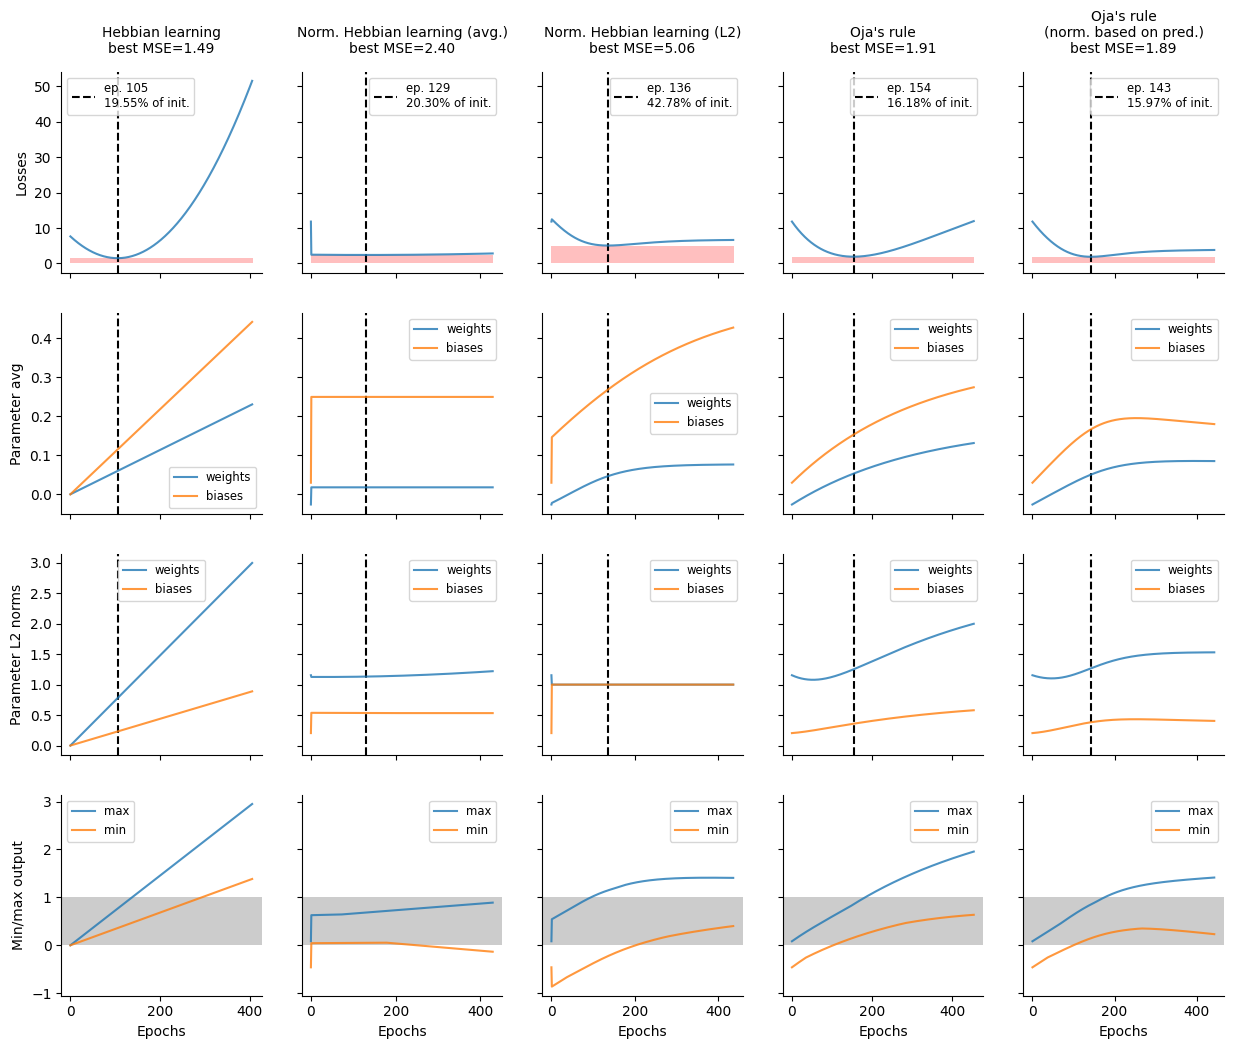

In [7]:
fig, axes = plt.subplots(4, len(RULES), sharex="col", sharey="row", figsize=(3 * len(RULES), 12))

if SEED is None:
    seed = np.random.randint(2**32 - 1)

all_records = dict()

all_Is, all_Os = init_data(n_Is=N_Is, n_O=N_O, n_ex=N_EX, seed=seed, O_factor=1)
for r, rule in enumerate(RULES.keys()):
    all_records[rule], _ = run_rule(all_Is, all_Os, ax1D=axes[:, r], rule=rule, seed=seed, max_epochs=MAX_EPOCHS)

polish_axes(axes)